In [1]:
from Pipeline import BLEPipeline, WifiPipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random, time

from itertools import izip, combinations

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Added for testing
from sklearn.metrics import roc_curve, roc_auc_score
import scikitplot as skplt

In [2]:
w = WifiPipeline()

In [3]:
df = w.make_dataframe()

Mini       104280
Router     103593
Dropcam     64568
Kasa        23753
Netcam3      4867
Netcam1      4446
Netcam2      4407
Switch2      3046
Switch1      2668
Switch3      2634
Insight      2556
Switch4      2206
Lifx2         627
TpPlug        587
Lifx1         540
TpBulb        202
Name: Name, dtype: int64


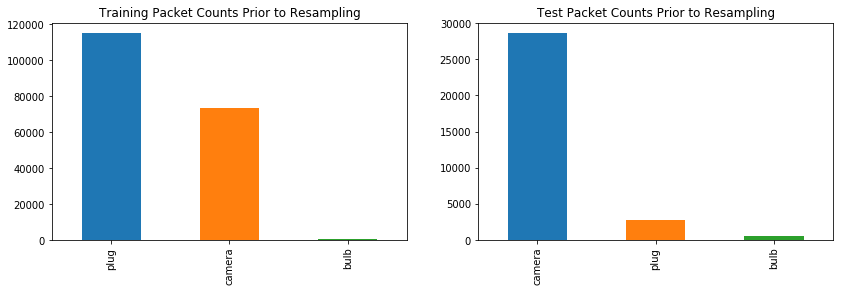

In [4]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
devtype_train = df_train["DeviceType"].value_counts()
plt.subplot(1, 2, 1) #
devtype_train.plot(kind='bar', title="Training Packet Counts Prior to Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
devtype_test = df_test["DeviceType"].value_counts()
plt.subplot(1, 2, 2)
devtype_test.plot(kind='bar', title="Test Packet Counts Prior to Resampling");


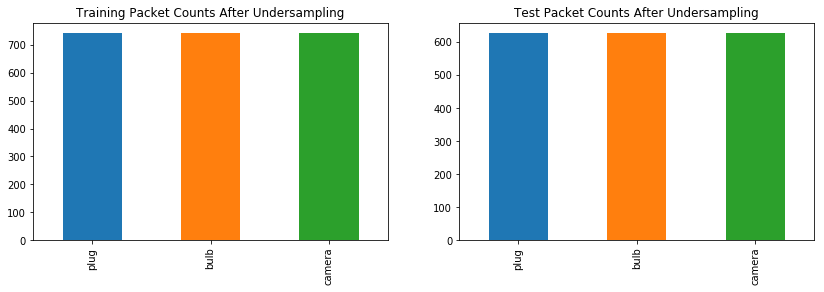

In [5]:
# 1st technique - Random undersampling: 
#     randomly removing packets of the majority classes to match the minority class

kind = "under"
category = "DeviceType"
df_train_undersampled = w.resample(df_train, kind=kind, category=category)
df_test_undersampled = w.resample(df_test, kind=kind, category=category)

# Plot changes
plt.subplots(1, 2, figsize=(14,4))

plt.subplot(1, 2, 1)
df_train_undersampled["DeviceType"].value_counts().plot(kind='bar', title="Training Packet Counts After Undersampling");

plt.subplot(1, 2, 2)
df_test_undersampled["DeviceType"].value_counts().plot(kind='bar', title="Test Packet Counts After Undersampling");

In [6]:
# Run One vs All  and One vs One classification strategies
features_list = [
        # Packet info
        "PacketLength", "Duration", 
        
        # Vendor 
         "Belkin", "Dropcam", "Lifi", "Netgear", "Tp-link",
    
        # 802.11 Data subtype
        "Data", "QoS_Data", "QoS_Null",

        # Associated Packets
        "Assoc_Packets"]

y_list = ["camera", "bulb", "plug"]

In [7]:
def test_printout_cm_metrics(device_type, cm_list, matrices, metrics):
        print "Device Type:", device_type
        print "=========================="
        
        for i, cm in enumerate(cm_list):
            print cm_list[i]
            print ""
            print "Confusion Matrix"
            print matrices[i]
            print ""
            print "Metrics"
            print metrics[i]
            print "---------------------------------------------------------"

In [8]:
def test_plot_cm_metrics():
    return "plots"

In [9]:
def test_one_vs_all_classify(df, features_list, y_list, output='print'):
        time_start = time.time()
        
        onevsall_dict = {}
        
        # Divide df by train and test devices
        df_test = df[df["Set"]=="test"]
        df_train = df[df["Set"]=="train"]
        
        # Train using chosen features
        X_train = df_train[features_list]
        X_test = df_test[features_list]
    
        for device_type in y_list:
            # Set one device type as y
            y_train = df_train[device_type]
            y_test = df_test[device_type]
    
            time_start_clf = time.time()
    
            rf_clf = w.random_forest_classifier(X_train, y_train, X_test, y_test)
            knn_clf = w.k_neighbors_classifier(X_train, y_train, X_test, y_test)
            lda_clf = w.lda_classifier(X_train, y_train, X_test, y_test)
    
            time_elapsed_clf = time.time() - time_start_clf

            # Get confusion matrices
            rf_cm = w.make_conf_matrix(y_test, rf_clf['Pred'], cm_type='binary')
            knn_cm = w.make_conf_matrix(y_test, knn_clf['Pred'], cm_type='binary')
            lda_cm = w.make_conf_matrix(y_test, lda_clf['Pred'], cm_type='binary')
            
            # Calculate metrics
            rf_metrics = w.calculate_cm_metrics(rf_cm)
            knn_metrics = w.calculate_cm_metrics(knn_cm)
            lda_metrics = w.calculate_cm_metrics(lda_cm)
            
#            print "Random Forest Score:", rf_clf['Score'], "Time: ", rf_clf['Time']
#            print "KNN Score:", knn_clf['Score'], "Time: ", knn_clf['Time']
#            print "LDA Score:", lda_clf['Score'], "Time: ", lda_clf['Time']
            
            if output == 'print':
                test_printout_cm_metrics(device_type,['RF','KNN','LDA'],[rf_cm, knn_cm, lda_cm],[rf_metrics, knn_metrics, lda_metrics])
                
                print "Total time (classifiers):", time_elapsed_clf
                print ""
            elif output == 'file':
                print 'file output'
                test_plot_cm_metrics(device_type,['RF','KNN','LDA'],[rf_cm, knn_cm, lda_cm],[rf_metrics, knn_metrics, lda_metrics])
            
            onevsall_dict[device_type] = {'RF': {'CM': rf_cm, 'Metrics':rf_metrics, 'Time':time_elapsed_clf},
                                          'KNN': {'CM': knn_cm, 'Metrics':knn_metrics, 'Time':time_elapsed_clf},
                                          'LDA': {'CM': lda_cm, 'Metrics':lda_metrics, 'Time':time_elapsed_clf}}
        
        total_time = time.time() - time_start
        print "Total time (one vs all_classify):", total_time
        print ""    
        
        return onevsall_dict, total_time

In [10]:
df_undersample = pd.concat([df_train_undersampled, df_test_undersampled], axis=0)

all_under_devtype = w.one_vs_all_classify(df_undersample, features_list, y_list)

Device Type: camera
RF

Confusion Matrix
Predicted  camera  rest
Actual                 
camera         87   540
rest           73  1181

Metrics
         FN   FP    TN    TP  Accuracy  Precision    Recall
camera  540   73  1181    87   0.67411   0.543750  0.138756
rest     73  540    87  1181   0.67411   0.686229  0.941786
---------------------------------------------------------
KNN

Confusion Matrix
Predicted  camera  rest
Actual                 
camera        198   429
rest          185  1069

Metrics
         FN   FP    TN    TP  Accuracy  Precision    Recall
camera  429  185  1069   198  0.673578   0.516971  0.315789
rest    185  429   198  1069  0.673578   0.713618  0.852472
---------------------------------------------------------
LDA

Confusion Matrix
Predicted  camera  rest
Actual                 
camera         38   589
rest           30  1224

Metrics
         FN   FP    TN    TP  Accuracy  Precision    Recall
camera  589   30  1224    38   0.67092   0.558824  0.060606
rest

In [11]:
one_under_devtype = w.one_vs_one_classify(df_undersample, features_list, y_list)

Device Pair: ('camera', 'bulb')
--------------------------
--------------------------
RF Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        627       0
camera       17     610 

RF Metrics
        FN  FP   TN   TP  Accuracy  Precision    Recall
bulb     0  17  610  627  0.986443   0.973602  1.000000
camera  17   0  627  610  0.986443   1.000000  0.972887 

--------------------------
KNN Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        623       4
camera        0     627 

KNN Metrics
        FN  FP   TN   TP  Accuracy  Precision   Recall
bulb     4   0  627  623   0.99681   1.000000  0.99362
camera   0   4  623  627   0.99681   0.993661  1.00000 

--------------------------
LDA Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        627       0
camera      181     446 

LDA Metrics
         FN   FP   TN   TP  Accuracy  Precision    Recall
bulb      0  181  446  627  0.855662    0.77599  1.000000
camera  181    0

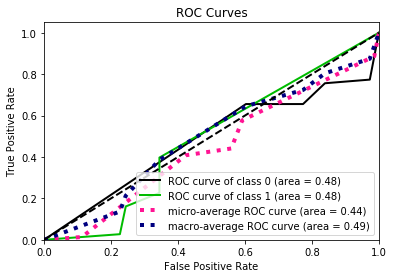

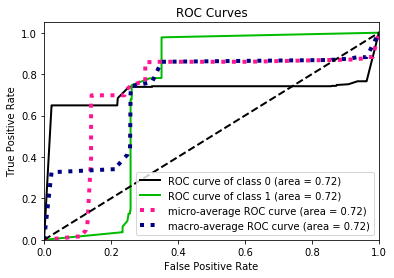

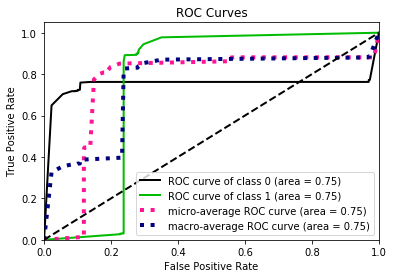

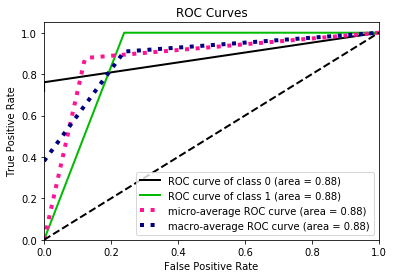

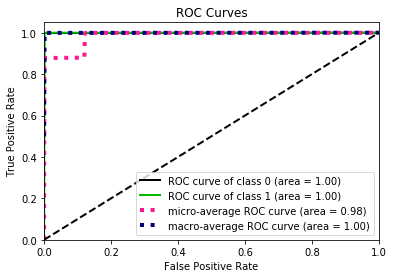

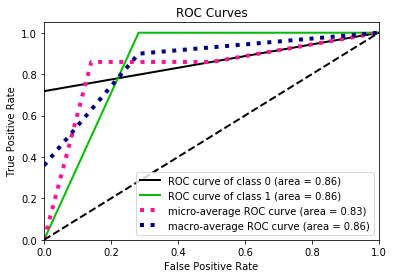

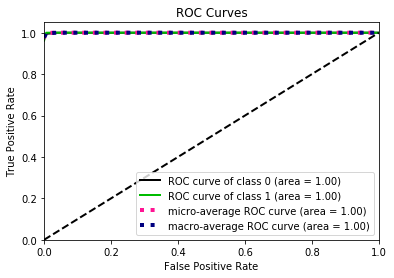

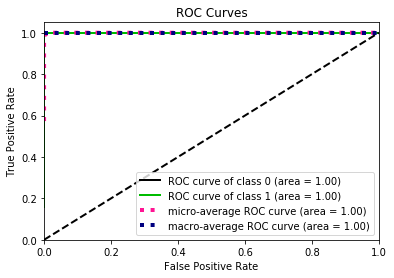

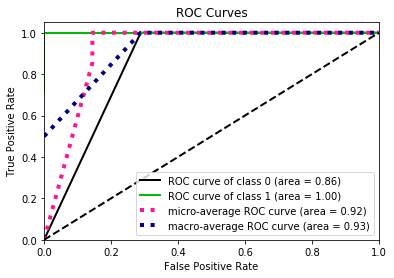

In [25]:
# Plotting ROC curves: vsone

# Extract devices and classifiers
dev_pairs = one_under_devtype[0].keys()
classifiers = one_under_devtype[0][dev_pairs[0]].keys()

for device in dev_pairs:
    for classifier in classifiers:
        # Extract predicted probas and y_true
        pred_proba = one_under_devtype[0][device][classifier]['Classifier']['Pred_Proba']
        true = one_under_devtype[0][device][classifier]['Classifier']['True']
        
        # Plot ROC curve
        fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
        auc = roc_auc_score(true, pred_proba[:,1])
        skplt.metrics.plot_roc(true, pred_proba);

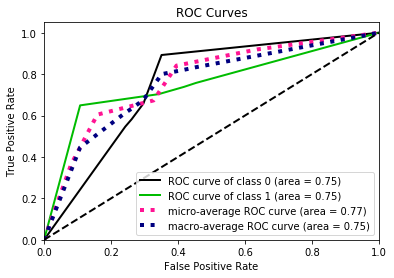

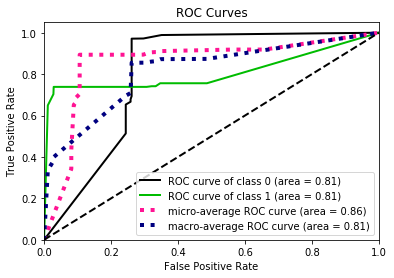

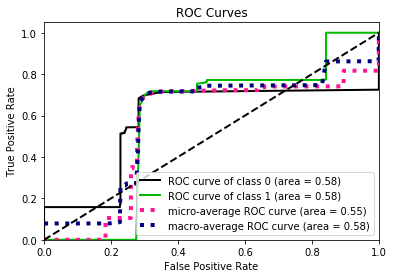

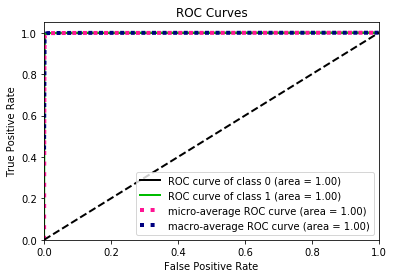

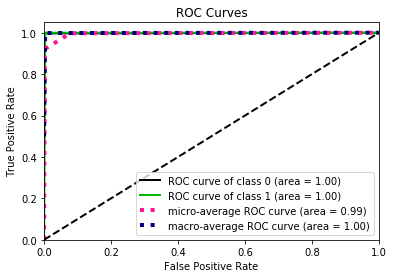

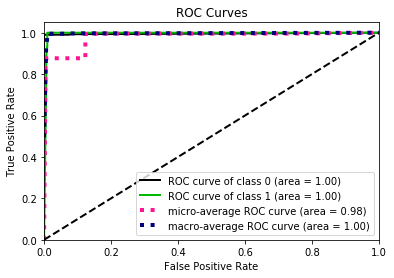

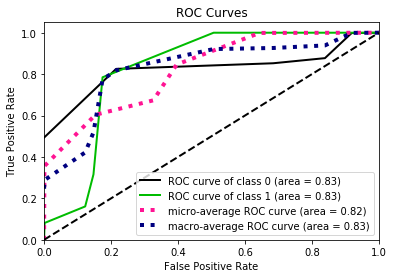

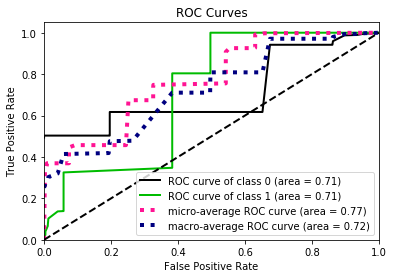

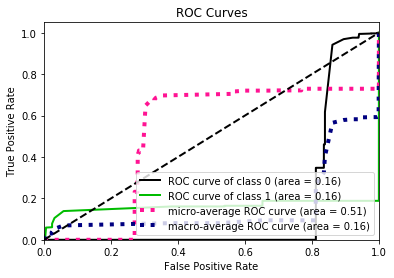

In [26]:
# Plotting ROC curves: vsall

# Extract devices and classifiers
dev_pairs = all_under_devtype[0].keys()
classifiers = all_under_devtype[0][dev_pairs[0]].keys()

for device in dev_pairs:
    for classifier in classifiers:
        # Extract predicted probas and y_true
        pred_proba = all_under_devtype[0][device][classifier]['Classifier']['Pred_Proba']
        true = all_under_devtype[0][device][classifier]['Classifier']['True']
        
        # Plot ROC curve
        fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
        auc = roc_auc_score(true, pred_proba[:,1])
        skplt.metrics.plot_roc(true, pred_proba);

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

class KNN_Pipeline():
    def __init__(self):
        self.knn = KNeighborsClassifier(n_neighbors=5, n_jobs=2)
        self.knn_model = None
    
    def k_neighbors_classifier(self, X_train, y_train, X_test, y_test):
        time_start = time.time()

        knn_model = self.knn.fit(X_train, y_train)
        
        preds = knn_model.predict(X_test)
        score = knn_model.score(X_test, y_test)
                
        time_elapsed = time.time() - time_start
        
        self.knn_model = knn_model
        return {'Score' : score, 'Time' : time_elapsed, 'Pred': preds}